Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [4]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [5]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [6]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "cifar10") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/240111_robust_tests/FAT/'
save_path_FedAvg = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/240111_robust_tests/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 177.35it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:15<00:00,  2.51it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [7]:
clients

In [17]:
clients[0].train_iterator.dataset.targets

tensor([0, 0, 6, 4, 6, 6, 4, 6, 9, 6, 4, 6, 6, 1, 5, 4, 8, 0, 7, 0, 6, 4, 4, 0,
        6, 6, 9, 0, 1, 9, 9, 9, 5, 6, 1, 0, 3, 4, 6, 9, 9, 6, 6, 1, 6, 4, 0, 0,
        4, 0, 9, 0, 5, 9, 6, 4, 0, 8, 9, 5, 3, 6, 6, 0, 4, 9, 5, 4, 9, 0, 6, 8,
        4, 4, 6, 9, 3, 6, 6, 9, 1, 9, 4, 6, 4, 0, 4, 4, 6, 9, 9, 9, 3, 4, 6, 0,
        4, 7, 6, 0, 0, 0, 6, 0, 5, 6, 6, 0, 0, 1, 0, 4, 4, 9, 3, 0, 6, 8, 1, 0,
        9, 2, 4, 6, 4, 4, 5, 9, 4, 9, 0, 9, 6, 9, 6, 9, 4, 6, 0, 0, 1, 1, 6, 0,
        9, 7, 4, 0, 4, 6, 9, 4, 5, 9, 6, 0, 0, 6, 9, 4, 6, 9, 2, 4, 9, 4, 4, 9,
        9, 0, 6, 6, 0, 4, 0, 6, 2, 4, 4, 4, 0, 7, 4, 9, 3, 6, 6, 0, 6, 4, 0, 0,
        9, 0, 6, 6, 0, 6, 6, 0, 0, 9, 9, 1, 0, 9, 4, 6, 0, 0, 4, 0, 6, 4, 0, 0,
        4, 0, 6, 9, 9, 9, 4, 4, 5, 0, 9, 4, 0, 6, 0, 0, 8, 0, 0, 6, 9, 6, 4, 8,
        2, 9, 0, 2, 9, 4, 9, 9, 9, 9, 5, 4, 0, 9, 4, 4, 9, 0, 9, 0, 4, 0, 8, 0,
        1, 6, 0, 9, 7, 0, 4, 4, 6, 0, 0, 9, 6, 6, 4, 6, 5, 5, 6, 0, 0, 0, 6, 4,
        3, 0, 5, 9, 4, 4, 0, 0, 4, 4, 6,

In [4]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 30
setting = 'FedAvg_adv'
num_users = [1,3,5,10]


test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 15


save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'


for num_user in num_users:
    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    aggregator, clients, args_ = set_args(setting, 40)

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FAT150)
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    aggregator.update_clients()
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()
    
    for c in aggregator.clients:
        c.unlearning_flag = True
    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator, model_FAT)

    prev_model = copy.deepcopy(model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
     # Assign proportion and attack params
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%5 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 184.17it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


round 0 Test acc:  0.8125 ( 0.0 ) adv acc:  0.38750001788139343 ( 0.0 )


/home/ubuntu/fedatk_unl_tj/learners/learner.py:189: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


round 5 Test acc:  0.625 ( 0.0 ) adv acc:  0.15000000596046448 ( 0.0 )
round 10 Test acc:  0.6625000238418579 ( 0.0 ) adv acc:  0.21250000596046448 ( 0.0 )
round 15 Test acc:  0.675000011920929 ( 0.0 ) adv acc:  0.22500000894069672 ( 0.0 )
round 20 Test acc:  0.6875 ( 0.0 ) adv acc:  0.26250001788139343 ( 0.0 )
round 25 Test acc:  0.699999988079071 ( 0.0 ) adv acc:  0.23749999701976776 ( 0.0 )
round 30 Test acc:  0.699999988079071 ( 0.0 ) adv acc:  0.2750000059604645 ( 0.0 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 229.34it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


round 0 Test acc:  0.8125 ( 0.010206197528198842 ) adv acc:  0.40416666865348816 ( 0.061520085857401645 )
round 5 Test acc:  0.5375000238418579 ( 0.04082483877978404 ) adv acc:  0.058333334823449455 ( 0.015590239509808415 )
round 10 Test acc:  0.6333333452542623 ( 0.02568505641187949 ) adv acc:  0.10833333432674408 ( 0.015590240173559018 )
round 15 Test acc:  0.6458333333333334 ( 0.031180475037115258 ) adv acc:  0.09583333631356557 ( 0.015590239509808416 )
round 20 Test acc:  0.6541666785875956 ( 0.011785129878515196 ) adv acc:  0.10833333681027095 ( 0.005892557914782846 )
round 25 Test acc:  0.6583333611488342 ( 0.011785101780616189 ) adv acc:  0.10416666915019353 ( 0.005892557914782846 )
round 30 Test acc:  0.6416666905085245 ( 0.02124592165363055 ) adv acc:  0.10416666666666667 ( 0.015590239509808416 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 239.97it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


round 0 Test acc:  0.7725000143051147 ( 0.0310241814252549 ) adv acc:  0.3475000083446503 ( 0.06294838644691302 )
round 5 Test acc:  0.6425000190734863 ( 0.050990189758792825 ) adv acc:  0.08000000156462192 ( 0.03588175084856408 )
round 10 Test acc:  0.6850000143051147 ( 0.07999999299645442 ) adv acc:  0.08250000178813935 ( 0.025739075844559336 )
round 15 Test acc:  0.7325000166893005 ( 0.05159942137371739 ) adv acc:  0.07500000074505805 ( 0.013693063121459062 )
round 20 Test acc:  0.7100000262260437 ( 0.07348468060341806 ) adv acc:  0.08500000238418579 ( 0.02669269613250208 )
round 25 Test acc:  0.7225000023841858 ( 0.07516648078170969 ) adv acc:  0.09000000208616257 ( 0.03824264796898408 )
round 30 Test acc:  0.6900000214576721 ( 0.07921489277314388 ) adv acc:  0.07500000149011612 ( 0.02738612896348528 )
==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 244.11it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


round 0 Test acc:  0.7762500166893005 ( 0.03970594690796908 ) adv acc:  0.328750005364418 ( 0.040716242278249236 )
round 5 Test acc:  0.6712500154972076 ( 0.04295711175922261 ) adv acc:  0.08625000193715096 ( 0.034663563241559475 )
round 10 Test acc:  0.6912500083446502 ( 0.0591740139548732 ) adv acc:  0.10125000253319741 ( 0.034663563349029404 )


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 13.81 MiB is free. Process 26817 has 1.50 GiB memory in use. Including non-PyTorch memory, this process has 13.05 GiB memory in use. Of the allocated memory 12.67 GiB is allocated by PyTorch, and 251.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

ValueError: x and y must have same first dimension, but have shapes (7,) and (3,)

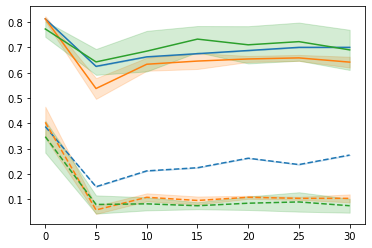

: 

In [5]:

# Initialize a new figure
plt.figure(figsize=(6, 4))

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 35, 5)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('ARU-E Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()